<a href="https://colab.research.google.com/github/ddooji/hanwha/blob/main/Agricultural_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#날씨 데이터 api
def get_data(startDt_, endDt_, stnIds_):
  from urllib.request import Request, urlopen
  from urllib.parse import urlencode, quote_plus
  import bs4
  import pandas as pd
  import numpy as np
  from datetime import timedelta

  url = 'http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList'
  my_key = '3Z5TJHKlsYRgrhme4N7VmDe99YdoeuXIR5858I5iDOf2/FNKsxHIQZOV5vWNQHLYjgD0LarxhiMN+7HmtdvqkA=='
  
  # 날짜 범위의 최대값을 '20210501'로 설정
  queryParams = '?' + urlencode({ quote_plus('ServiceKey') : my_key, quote_plus('pageNo') : '1', quote_plus('numOfRows') : '999', quote_plus('dataType') : 'XML', quote_plus('dataCd') : 'ASOS', quote_plus('dateCd') : 'DAY', quote_plus('startDt') : startDt_ , quote_plus('endDt') : endDt_, quote_plus('stnIds') : stnIds_ })

  request = Request(url + queryParams)
  request.get_method = lambda: 'GET'
  response_body = urlopen(request).read()

  xmlobj = bs4.BeautifulSoup(response_body, 'lxml-xml')
  items = xmlobj.findAll('item')

  ## 원하는 형태로 가공
  asos = pd.DataFrame()
  for i in items:
    dic_ = {}
    for j in i.find_all():
      dic_[j.name] = [j.text]
    asos = pd.concat([asos,pd.DataFrame(dic_)],axis=0,ignore_index=True)

  max_ = pd.to_datetime(asos['tm'], format = '%Y-%m-%d').max()
  max_1 = max_ + timedelta(days=1)

  set_startDt_ = str(max_1.date()).replace('-','')

  # 저장된 데이터 프레임과 다음 요청 시 시작될 날짜를 반환
  return asos, set_startDt_


In [3]:
#데이터 불러오기
#######수정(날짜, 지역)
import pandas as pd

startDt_ = '20160201'
stnIds_ = '268' #진도군으로 수정

asos_ = pd.DataFrame()
#asos_ = get_data(startDt_, endDt_, stnIds_)

while startDt_ != '20211001':
    temp_asos_, startDt_ = get_data(startDt_,'20210930',stnIds_)
    asos_ = pd.concat([asos_,temp_asos_],axis=0 ,ignore_index=True)

In [4]:
#필요 데이터 컬럼만 슬라이싱
asos_a = asos_.loc[:, ['avgTa','minTa', 'maxTa', 'sumRn', 'avgRhm', 'sumSsHr']] #평균기온, 최저기온, 최고기온, 일강수량, 평균상대습도, 합계일조시간
asos_tm = asos_.loc[:, ['tm']] #날짜

In [7]:
#object to numeric
asos_a = asos_a.apply(pd.to_numeric)

#sumRn 결측치 NaN -> 0
asos_a[['sumRn']] = asos_a[['sumRn']].fillna(0)

In [5]:
asos_a

,avgTa,minTa,maxTa,sumRn,avgRhm,sumSsHr
0,11.6,7.7,17.0,0.9,91.1,0.9
1,12.3,5.8,20.7,,82.5,9.0
2,14.1,9.3,19.3,,81.1,6.6


In [8]:
#가격 빈곳(주말, 공휴일) 최근 이전 날짜 가격 넣기
import numpy as np

data_length = len(asos_a)
for i in range(0, data_length) :
  if np.isnan(asos_a['avgTa'].at[i]) :
    asos_a['avgTa'].at[i] = asos_a['avgTa'].at[i-1]
  if np.isnan(asos_a['minTa'].at[i]) :
    asos_a['minTa'].at[i] = asos_a['minTa'].at[i-1]
  if np.isnan(asos_a['maxTa'].at[i]) :
    asos_a['maxTa'].at[i] = asos_a['maxTa'].at[i-1]
  if np.isnan(asos_a['avgRhm'].at[i]) :
    asos_a['avgRhm'].at[i] = asos_a['avgRhm'].at[i-1]
  if np.isnan(asos_a['sumSsHr'].at[i]) :
    asos_a['sumSsHr'].at[i] = asos_a['sumSsHr'].at[i-1]

In [9]:
# 합치기
asos_all = pd.concat([asos_tm, asos_a], axis=1)

In [ ]:
#전체 데이터 결측치 확인
asos_all.dtypes
asos_all.isnull().values.any()

False

In [10]:
#날씨 데이터 확인
asos_all

,tm,avgTa,minTa,maxTa,sumRn,avgRhm,sumSsHr
0,2021-10-30,11.6,7.7,17.0,0.9,91.1,0.9
1,2021-10-31,12.3,5.8,20.7,0.0,82.5,9.0
2,2021-11-01,14.1,9.3,19.3,0.0,81.1,6.6


In [ ]:
#대파 가격 api
def get_gonion_data(startDt_, endDt_):
  from urllib.request import Request, urlopen
  from urllib.parse import urlencode, quote_plus
  import bs4
  import pandas as pd
  import numpy as np
  from datetime import timedelta

  url = 'http://www.kamis.or.kr/service/price/xml.do?action=periodProductList'
  my_key = 'abca31a9-627c-4468-986d-74f0303e57b4'
  
  # 날짜 범위의 최대값을 '20210501'로 설정
  queryParams = '&' + urlencode({ quote_plus('p_cert_key') : my_key, quote_plus('p_cert_id') : 'suji56789', quote_plus('p_returntype') : 'xml', quote_plus('p_startday') : startDt_, quote_plus('p_endday') : endDt_, quote_plus('p_productclscode') : '02', quote_plus('p_itemcategorycode') : '200' , quote_plus('p_itemcode') : '246', quote_plus('p_productrankcode') : '04', quote_plus('p_countrycode') : '1101', quote_plus('p_convert_kg_yn') : 'N' })
  #p_countrycode 1101:서울, 2100:부산, 2200:대구, 2401:광주, 2501:대전

  request = Request(url + queryParams)
  request.get_method = lambda: 'GET'
  response_body = urlopen(request).read()

  xmlobj = bs4.BeautifulSoup(response_body, 'lxml-xml')
  items = xmlobj.findAll('item')

  ## 원하는 형태로 가공
  g_onion = pd.DataFrame()
  for i in items:
    dic_ = {}
    for j in i.find_all():
      if j.name == 'countyname' :
        if j.text == '서울' :
          dic_[j.name] = [j.text]
      else :
        dic_[j.name] = [j.text]
    g_onion = pd.concat([g_onion,pd.DataFrame(dic_)],axis=0)
  
  return g_onion

In [ ]:
#데이터 불러오기
import pandas as pd

g_onion = pd.DataFrame()
g_onion = get_gonion_data('2016-03-01','2021-10-31')

In [ ]:
#필요데이터 슬라이싱, countyname 지역 외 평균/평년 제거 
g_onion_S = g_onion.loc[:, ['itemname',	'kindname',	'countyname',	'marketname',	'yyyy',	'regday',	'price']]
g_onion_S = g_onion_S.dropna(subset=['countyname'])

In [ ]:
#필요데이터 슬라이싱, 값 변경
g_onion_S = g_onion_S.loc[:, ['yyyy',	'regday',	'price']]
g_onion_S['regday'] = g_onion_S['regday'].str.replace("/","-")
g_onion_S['price'] = g_onion_S['price'].str.replace(",","")

#날짜 합치기, 짜르기
g_onion_S['yyyy'] = g_onion_S['yyyy'] + "-" + g_onion_S['regday']
g_onion_S.rename(columns = {'yyyy' : 'tm'}, inplace = True)
g_onion_S = g_onion_S.loc[:, ['tm',	'price']]

# 데이터 형태 변경
g_onion_S['price'] = g_onion_S['price'].apply(pd.to_numeric)
g_onion_S['tm'] = g_onion_S['tm'].apply(pd.to_datetime)

In [ ]:
#날짜 계산
#2016-02-01 날씨 + 2016-03-01 가격 매칭위해 날짜 조정 (1달로 수정)
from datetime import datetime, timedelta

g_onion_S['tm'] = g_onion_S['tm'] + timedelta(days=-30)

In [ ]:
#데이터 형태 재변경(OUTER JOIN)
g_onion_S['tm'] = g_onion_S['tm'].astype(str)

In [ ]:
#LEFT OUTER JOIN 날짜기준
data_all = pd.merge(left = asos_all , right = g_onion_S, how = "left", on = "tm")

In [ ]:
#결측치 NaN -> 0 
data_all = data_all.fillna(0)

#가격 빈곳(주말, 공휴일) 최근 이전 날짜 가격 넣기
data_length = len(data_all)
for i in range(0, data_length) :
  if data_all['price'].at[i] == 0.0 :
    data_all['price'].at[i] = data_all['price'].at[i-1]

In [ ]:
#데이터 확인
data_all

,tm,avgTa,minTa,maxTa,sumRn,avgRhm,sumSsHr,price
0,2016-02-01,-0.2,-1.6,1.7,0.0,75.5,2.6,2500.0
1,2016-02-02,0.1,-1.2,2.2,0.0,70.1,7.1,2500.0
2,2016-02-03,0.2,-3.8,4.9,0.0,67.8,8.9,2500.0
3,2016-02-04,1.2,-4.9,6.8,0.0,74.6,6.8,2500.0
4,2016-02-05,1.7,-1.7,5.2,0.0,75.8,8.8,2500.0
...,...,...,...,...,...,...,...,...
2064,2021-09-26,21.4,18.5,25.4,0.0,80.4,1.2,1800.0
2065,2021-09-27,22.5,18.6,26.9,0.0,76.4,7.7,1850.0
2066,2021-09-28,22.4,20.2,24.6,0.1,81.1,0.0,1870.0
2067,2021-09-29,23.5,21.2,26.3,32.4,92.9,0.2,1900.0


In [ ]:
#결측치 확인
data_all.isnull().values.any()

False

In [ ]:
#데이터 분석 시작
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from collections import Counter

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
mydata.plot(figsize = (8,5))

In [ ]:
test_train = data_all.drop(['avgTa', 'minTa','maxTa','sumRn','avgRhm', 'sumSsHr'], axis = 1)
mydata = data_all.drop(['tm'], axis = 1)

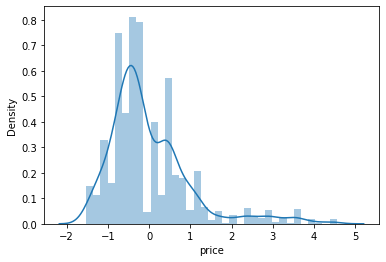

In [ ]:
#target 로그?
sns.distplot(data_df['price']);

In [ ]:
standard = StandardScaler()

mydata = standard.fit_transform(mydata)

In [ ]:
column_names = ['avgTa', 'minTa','maxTa','sumRn','avgRhm', 'sumSsHr','price']
data_df = pd.DataFrame(mydata, columns = column_names)

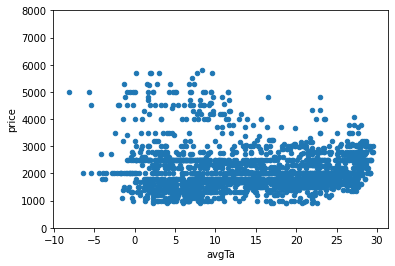

In [ ]:
#선형관계 확인
var = 'avgTa'
data = pd.concat([data_all['price'], data_all[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(0,8000));

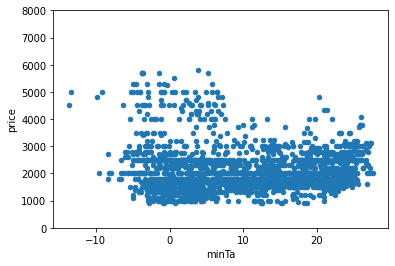

In [ ]:
#선형관계 확인
var = 'minTa'
data = pd.concat([data_all['price'], data_all[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(0,8000));

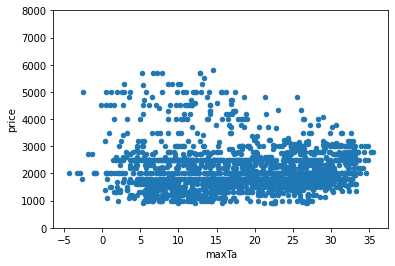

In [ ]:
#선형관계 확인
var = 'maxTa'
data = pd.concat([data_all['price'], data_all[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(0,8000));

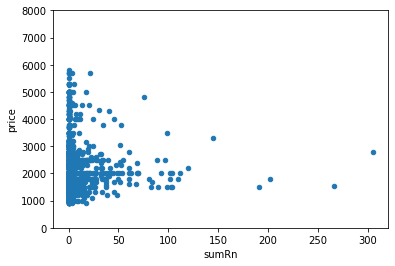

In [ ]:
#선형관계 확인
var = 'sumRn'
data = pd.concat([data_all['price'], data_all[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(0,8000));

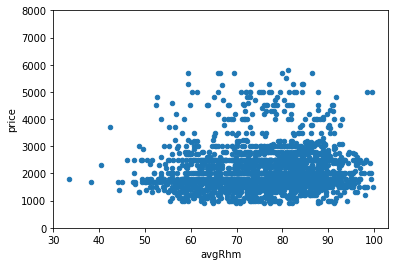

In [ ]:
#선형관계 확인
var = 'avgRhm'
data = pd.concat([data_all['price'], data_all[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(0,8000));

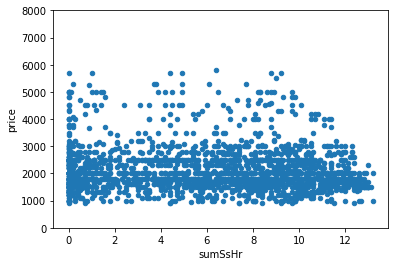

In [ ]:
#선형관계 확인
var = 'sumSsHr'
data = pd.concat([data_all['price'], data_all[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(0,8000));

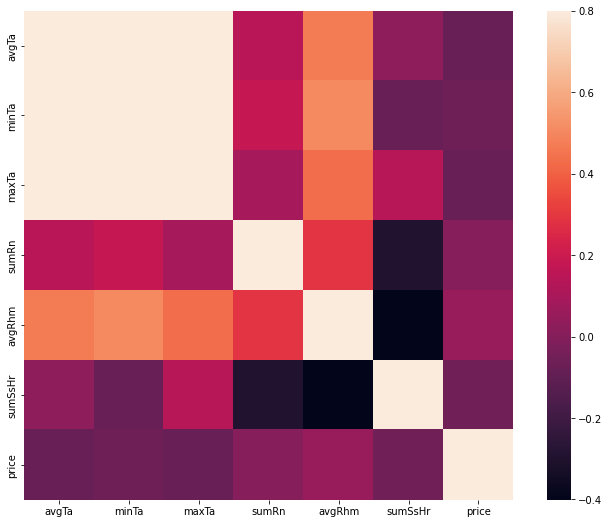

In [ ]:
#correlation matrix
corrmat = data_all.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
#test_train 쪼개기 전 target 정규화
test_train = data_df
#test_train['price'] = test_train['price'].apply(lambda x: np.log1p(x))

In [ ]:
#target 로그?
sns.distplot(test_train['price']);

NameError: ignored

In [ ]:
from sklearn.model_selection import train_test_split

X = test_train.drop(['price'], axis = 1)

In [ ]:
y = test_train.drop(['avgTa', 'minTa','maxTa','sumRn','avgRhm', 'sumSsHr'], axis = 1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=10)

In [ ]:
from sklearn.linear_model import LinearRegression

lr=LinearRegression()
model = lr.fit(X_train, y_train)


print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.03267982594498309
-0.22861031436054868


In [ ]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     8.114
Date:                Thu, 25 Nov 2021   Prob (F-statistic):           1.21e-08
Time:                        00:09:54   Log-Likelihood:                -1220.4
No. Observations:                1448   AIC:                             2455.
Df Residuals:                    1441   BIC:                             2492.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1985      0.015    -13.388      0.000      -0.228      -0.169
avgTa          0.1647      0.172      0.957      0.339      -0.173       0.502
minTa          0.1249      0.094      1.334      0.182      -0.059       0.309
maxTa         -0.2404      0.102     -2.366      0.018      -0.440      -0.041
sumRn         -0.0086      0.017     -0.504      0.614      -0.042       0.025
avgRhm         0.0471      0.019      2.418      0.016       0.009       0.085
sumSsHr        0.0436      0.020      2.222      0.026       0.005       0.082
==============================================================================
Omnibus:                       63.196   Durbin-Watson:                   0.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.799
Skew:                           0.424   Prob(JB):                     4.64e-13
Kurtosis:                       2.529   Cond. No.                         26.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

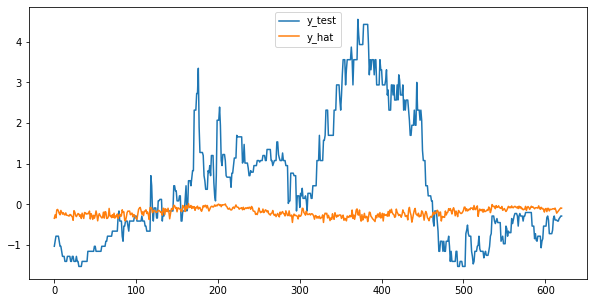

In [ ]:
y_hat = lr.predict(X_test)

plt.figure(figsize=(10,5))

y_test_array = y_test.to_numpy()

plt.plot(y_test_array, label='y_test')
plt.plot(y_hat, label='y_hat')
plt.legend(loc='upper center')
plt.show()

In [ ]:
#시계열분석

test_train = data_all.drop(['avgTa', 'minTa','maxTa','sumRn','avgRhm', 'sumSsHr'], axis = 1)

In [ ]:
test_train

,tm,price
0,2016-02-01,7.824446
1,2016-02-02,7.824446
2,2016-02-03,7.824446
3,2016-02-04,7.824446
4,2016-02-05,7.824446
...,...,...
2064,2021-09-26,7.496097
2065,2021-09-27,7.523481
2066,2021-09-28,7.534228
2067,2021-09-29,7.550135


In [ ]:
test_train['tm'] = pd.to_datetime(test_train['tm'])


tm       datetime64[ns]
price           float64
dtype: object

In [ ]:
test_train.index = test_train['tm']
test_train.set_index('tm', inplace=True)

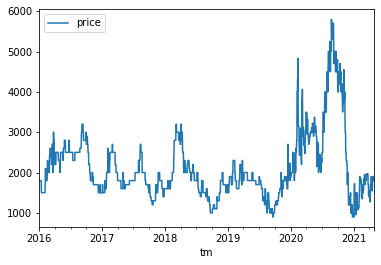

In [ ]:
test_train.plot()
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(test_train.price.values, order=(2,1,2))

#trend : constant를 가지고 있는지, c - constant / nc - no constant
#disp : 수렴 정보를 나타냄
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1946
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -12358.375
Method:                       css-mle   S.D. of innovations            138.616
Date:                Mon, 22 Nov 2021   AIC                          24728.751
Time:                        02:10:29   BIC                          24762.192
Sample:                             1   HQIC                         24741.047
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0411      2.248      0.018      0.985      -4.364       4.446
ar.L1.D.y      0.2238      0.382      0.586      0.558      -0.524       0.972
ar.L2.D.y      0.3305      0.303      1.090      0.2

In [ ]:
from fbprophet import Prophet

test_train.rename(columns = {'tm' : 'ds'}, inplace = True)
test_train.rename(columns = {'price' : 'y'}, inplace = True)

In [ ]:
test_train['ds'] = pd.to_datetime(test_train['ds'])

In [ ]:
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(test_train)

In [ ]:
# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=60, freq='d')
forecast_data = prophet.predict(future_data)
#forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

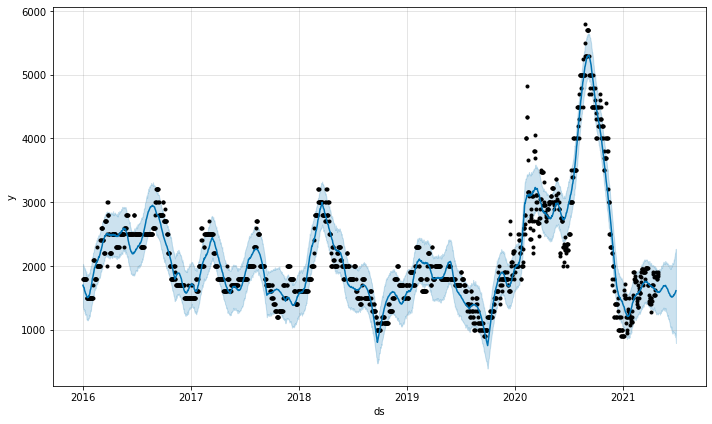

In [ ]:
fig1 = prophet.plot(forecast_data)

# VAR시계열

 참고 : 
 https://dining-developer.tistory.com/32

In [ ]:
################################# VAR시계열

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data_all

,tm,avgTa,minTa,maxTa,sumRn,avgRhm,sumSsHr,price
0,2016-02-01,-0.2,-1.6,1.7,0.0,75.5,2.6,2500.0
1,2016-02-02,0.1,-1.2,2.2,0.0,70.1,7.1,2500.0
2,2016-02-03,0.2,-3.8,4.9,0.0,67.8,8.9,2500.0
3,2016-02-04,1.2,-4.9,6.8,0.0,74.6,6.8,2500.0
4,2016-02-05,1.7,-1.7,5.2,0.0,75.8,8.8,2500.0
...,...,...,...,...,...,...,...,...
2064,2021-09-26,21.4,18.5,25.4,0.0,80.4,1.2,1800.0
2065,2021-09-27,22.5,18.6,26.9,0.0,76.4,7.7,1850.0
2066,2021-09-28,22.4,20.2,24.6,0.1,81.1,0.0,1870.0
2067,2021-09-29,23.5,21.2,26.3,32.4,92.9,0.2,1900.0


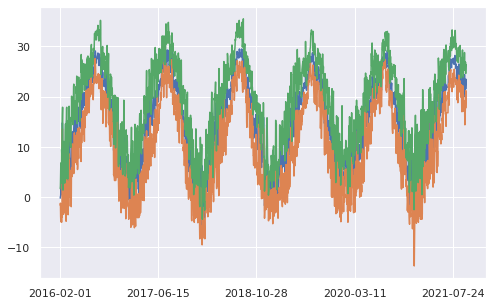

In [ ]:
data_all['avgTa'].plot(figsize = (8,5))
data_all['minTa'].plot(figsize = (8,5))
data_all['maxTa'].plot(figsize = (8,5))

In [ ]:

data_all['sumRn'].plot(figsize = (8,5))

In [ ]:
data_all['avgRhm'].plot(figsize = (8,5))

In [ ]:
data_all['sumSsHr'].plot(figsize = (8,5))

In [ ]:
data_all['price'].plot(figsize = (8,5))

In [ ]:
#'avgTa', 'minTa','maxTa','sumRn','avgRhm', 'sumSsHr
adfuller_test = adfuller(data_all['avgTa'], autolag= "AIC")
print('avgTa')
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

adfuller_test = adfuller(data_all['minTa'], autolag= "AIC")
print('minTa')
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

adfuller_test = adfuller(data_all['maxTa'], autolag= "AIC")
print('maxTa')
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

adfuller_test = adfuller(data_all['sumRn'], autolag= "AIC")
print('sumRn')
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

adfuller_test = adfuller(data_all['avgRhm'], autolag= "AIC")
print('avgRhm')
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

adfuller_test = adfuller(data_all['sumSsHr'], autolag= "AIC")
print('sumSsHr')
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

adfuller_test = adfuller(data_all['price'], autolag= "AIC")
print('price')
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

avgTa
ADF test statistic: -2.822386364231474
p-value: 0.05514650265777109
minTa
ADF test statistic: -2.6095003018568996
p-value: 0.09104960240188026
maxTa
ADF test statistic: -2.7052708408863206
p-value: 0.07313061605162452
sumRn
ADF test statistic: -38.5114902486257
p-value: 0.0
avgRhm
ADF test statistic: -4.373183421455798
p-value: 0.00033100502330635597
sumSsHr
ADF test statistic: -8.966005721675872
p-value: 7.986102501156467e-15
price
ADF test statistic: -3.1864977816147606
p-value: 0.020779664673874296


In [ ]:
data_length = len(data_all)
data_all_ch = data_all
for i in range(0, data_length) :
  data_all_ch.rename(index = {i: data_all['tm'].at[i]}, inplace = True)

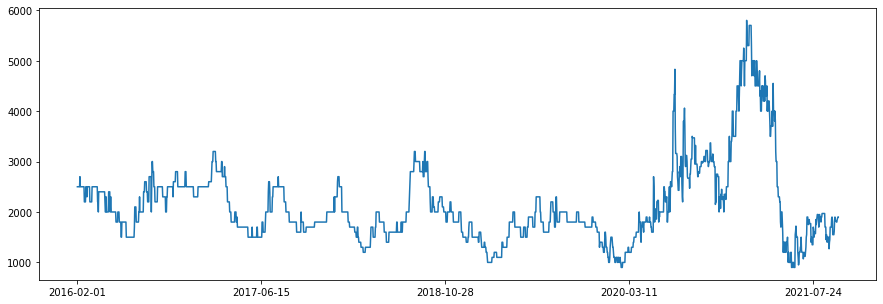

In [ ]:
data_all_ch['price'].plot(figsize = (15,5))

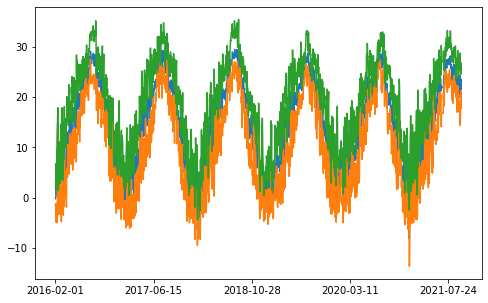

In [ ]:
data_all['avgTa'].plot(figsize = (8,5))
data_all['minTa'].plot(figsize = (8,5))
data_all['maxTa'].plot(figsize = (8,5))

In [ ]:
data_all_ch = data_all_ch.iloc[:,1:]

In [ ]:
#차분
data_all_diff = data_all_ch.diff().dropna()

In [ ]:
#'avgTa', 'minTa','maxTa','sumRn','avgRhm', 'sumSsHr
adfuller_test = adfuller(data_all_diff['avgTa'], autolag= "AIC")
print('avgTa')
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

adfuller_test = adfuller(data_all_diff['minTa'], autolag= "AIC")
print('minTa')
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

adfuller_test = adfuller(data_all_diff['maxTa'], autolag= "AIC")
print('maxTa')
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

adfuller_test = adfuller(data_all_diff['sumRn'], autolag= "AIC")
print('sumRn')
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

adfuller_test = adfuller(data_all_diff['avgRhm'], autolag= "AIC")
print('avgRhm')
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

adfuller_test = adfuller(data_all_diff['sumSsHr'], autolag= "AIC")
print('sumSsHr')
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

adfuller_test = adfuller(data_all_diff['price'], autolag= "AIC")
print('price')
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

avgTa
ADF test statistic: -7.291190157397282
p-value: 1.4158102446978072e-10
minTa
ADF test statistic: -8.482664840244963
p-value: 1.379672407318317e-13
maxTa
ADF test statistic: -8.15573763615403
p-value: 9.431142913687953e-13
sumRn
ADF test statistic: -15.550109454897324
p-value: 2.1053251043468936e-28
avgRhm
ADF test statistic: -14.815705373457671
p-value: 1.998790944304155e-27
sumSsHr
ADF test statistic: -16.20872321319436
p-value: 4.007021259227396e-29
price
ADF test statistic: -21.565649735447394
p-value: 0.0


In [ ]:
data_all_diff_a = data_all_diff.iloc[:, 6:]
train = data_all_diff.iloc[:-10,:]
test = data_all_diff.iloc[-10:,:]

In [ ]:
train

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


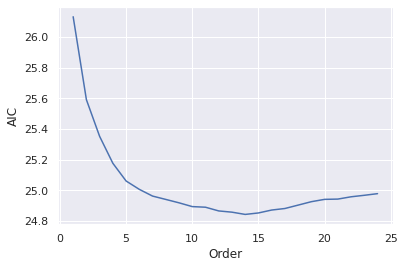

In [ ]:
forecasting_model = VAR(train)
results_aic = []
for p in range(1,25):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

sns.set()
plt.plot(list(np.arange(1,25,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()
#14번째 24.84298296805293,

In [ ]:
results_aic

[26.13277205528852,
 25.591514947222002,
 25.352114660954207,
 25.176558079385888,
 25.06101102636885,
 25.00640456212201,
 24.96260501884026,
 24.940765784739803,
 24.918625361539657,
 24.893995109619226,
 24.889954635306477,
 24.86571021557347,
 24.857647724792564,
 24.84298296805293,
 24.85251982228978,
 24.871537881099936,
 24.881557862754917,
 24.9037252280943,
 24.926067485347737,
 24.94119294030239,
 24.94301973198639,
 24.957964897560814,
 24.96776074700844,
 24.978420019286748]

In [ ]:
results = forecasting_model.fit(14)
results.summary()

In [ ]:
laaged_values = train.values[-14:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=10), index = test.index, columns= ['avgTa_d1','minTa_d1','maxTa_d1','sumRn_d1','avgRhm_d1','sumSsHr_d1','price_d1'])
forecast

,avgTa_d1,minTa_d1,maxTa_d1,sumRn_d1,avgRhm_d1,sumSsHr_d1,price_d1
2021-09-21,0.971473,2.349192,1.586479,0.662264,2.808954,-5.313261,-6.585310
2021-09-22,-0.511608,0.280763,-1.209325,3.409286,1.895465,-0.594925,-69.740062
2021-09-23,0.088169,0.141945,-0.011503,-0.616362,-1.221104,0.569456,-5.409575
2021-09-24,-0.244928,-0.427419,-0.123454,1.937265,-1.026973,-0.156657,-22.509292
2021-09-25,-0.319944,0.117408,-0.721423,2.927764,-0.129479,-1.022223,-42.509913
2021-09-26,-0.000685,0.178899,-0.132946,-6.021819,-1.564473,1.564461,-3.218657
2021-09-27,0.071422,-0.179790,0.363021,-0.436335,-0.053505,-0.230531,19.247591
2021-09-28,0.060936,0.197653,0.006857,1.250414,-1.086391,-0.426916,4.384930
2021-09-29,0.051782,-0.160187,0.369887,-2.390155,0.444233,0.715094,32.586806
2021-09-30,0.132069,-0.318387,0.315941,-0.614116,1.495750,-0.130072,7.689916


In [ ]:
forecast["avgTa"] = data_all_ch["avgTa"].iloc[-10-1] + forecast['avgTa_d1'].cumsum()
forecast["minTa"] = data_all_ch["minTa"].iloc[-10-1] + forecast['minTa_d1'].cumsum()
forecast["maxTa"] = data_all_ch["maxTa"].iloc[-10-1] + forecast['maxTa_d1'].cumsum()
forecast["sumRn"] = data_all_ch["sumRn"].iloc[-10-1] + forecast['sumRn_d1'].cumsum()
forecast["avgRhm"] = data_all_ch["avgRhm"].iloc[-10-1] + forecast['avgRhm_d1'].cumsum()
forecast["sumSsHr"] = data_all_ch["sumSsHr"].iloc[-10-1] + forecast['sumSsHr_d1'].cumsum()
forecast["price"] = data_all_ch["price"].iloc[-10-1] + forecast['price_d1'].cumsum()
forecast

,avgTa_d1,minTa_d1,maxTa_d1,sumRn_d1,avgRhm_d1,sumSsHr_d1,price_d1,avgTa,minTa,maxTa,sumRn,avgRhm,sumSsHr,price
2021-09-21,0.971473,2.349192,1.586479,0.662264,2.808954,-5.313261,-6.585310,24.471473,19.949192,29.386479,0.662264,83.908954,4.586739,1843.414690
2021-09-22,-0.511608,0.280763,-1.209325,3.409286,1.895465,-0.594925,-69.740062,23.959865,20.229955,28.177154,4.071550,85.804419,3.991815,1773.674629
2021-09-23,0.088169,0.141945,-0.011503,-0.616362,-1.221104,0.569456,-5.409575,24.048034,20.371900,28.165651,3.455188,84.583315,4.561270,1768.265054
2021-09-24,-0.244928,-0.427419,-0.123454,1.937265,-1.026973,-0.156657,-22.509292,23.803106,19.944482,28.042197,5.392452,83.556343,4.404614,1745.755761
2021-09-25,-0.319944,0.117408,-0.721423,2.927764,-0.129479,-1.022223,-42.509913,23.483162,20.061890,27.320774,8.320217,83.426864,3.382391,1703.245848
2021-09-26,-0.000685,0.178899,-0.132946,-6.021819,-1.564473,1.564461,-3.218657,23.482477,20.240789,27.187827,2.298398,81.862390,4.946852,1700.027191
2021-09-27,0.071422,-0.179790,0.363021,-0.436335,-0.053505,-0.230531,19.247591,23.553899,20.060999,27.550849,1.862064,81.808885,4.716321,1719.274783
2021-09-28,0.060936,0.197653,0.006857,1.250414,-1.086391,-0.426916,4.384930,23.614835,20.258652,27.557706,3.112477,80.722494,4.289405,1723.659712
2021-09-29,0.051782,-0.160187,0.369887,-2.390155,0.444233,0.715094,32.586806,23.666617,20.098465,27.927593,0.722322,81.166727,5.004499,1756.246518
2021-09-30,0.132069,-0.318387,0.315941,-0.614116,1.495750,-0.130072,7.689916,23.798687,19.780078,28.243534,0.108206,82.662477,4.874427,1763.936434


In [ ]:
test = data_all_ch.iloc[-10:,:]
test["avgTa_forecasted"] = forecast["avgTa"]
test["minTa_forecasted"] = forecast["minTa"]
test["maxTa_forecasted"] = forecast["maxTa"]
test["sumRn_forecasted"] = forecast["sumRn"]
test["avgRhm_forecasted"] = forecast["avgRhm"]
test["sumSsHr_forecasted"] = forecast["sumSsHr"]
test["price_forecasted"] = forecast["price"]
test.plot()

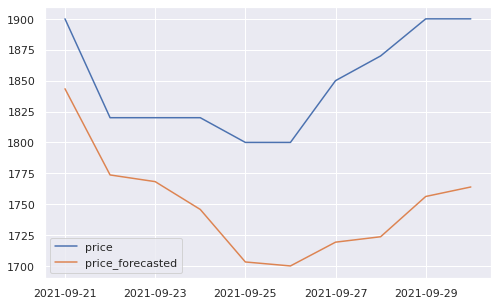

In [ ]:
test['price'].plot()
test['price_forecasted'].plot(figsize = (8,5))
plt.legend(loc='best')

In [ ]:
test['price_forecasted'] = test['price_forecasted']+80

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


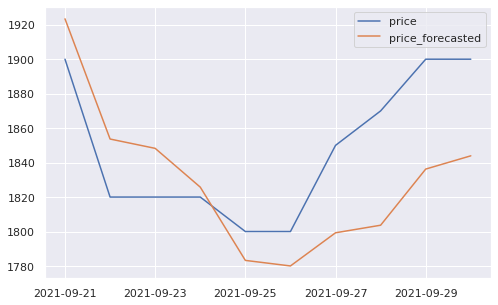

In [ ]:
test['price'].plot()
test['price_forecasted'].plot(figsize = (8,5))
plt.legend(loc='best')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

scaler = MinMaxScaler()

testa = scaler.fit_transform(test[['price_forecasted']].to_numpy())
testb = scaler.fit_transform(test[['price']].to_numpy())

MSE=mean_squared_error(testa, testb)
RMSE=mean_squared_error(test[['price_forecasted']],test[['price']])**0.5 

print("MSE : ", MSE)
print("RMSE : ", RMSE)

MSE :  0.1286136379251941
RMSE :  41.6840453653798


In [ ]:
testb

array([[1. ],
       [0.2],
       [0.2],
       [0.2],
       [0. ],
       [0. ],
       [0.5],
       [0.7],
       [1. ],
       [1. ]])

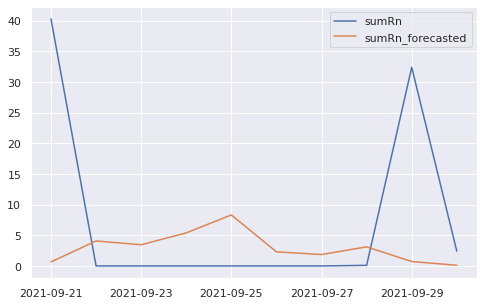

In [ ]:
test['sumRn'].plot()
test['sumRn_forecasted'].plot(figsize = (8,5))
plt.legend(loc='best')

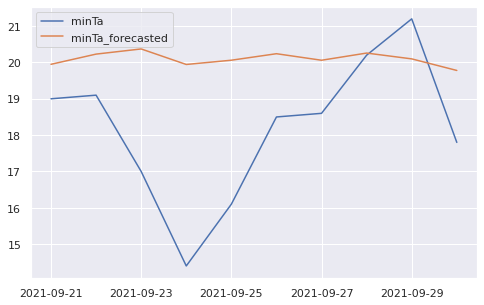

In [ ]:
test['minTa'].plot()
test['minTa_forecasted'].plot(figsize = (8,5))
plt.legend(loc='best')